In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from pathlib import Path


In [ ]:
# Ruta base de los datos
def recogida_df(ciudad):
    base_path = Path(f"../../data/raw/Open_Meteo/diarios/{ciudad}_data")
    print("Ruta absoluta:", base_path.resolve())

    # Lista para almacenar DataFrames individuales
    dfs = []

    for entry in base_path.glob("*"):
        print(f"[DEBUG] Elemento encontrado: {entry.name} (¿Es directorio? {entry.is_dir()})")
        
        if entry.is_dir() and entry.name.isdigit():  # Filtra solo directorios con nombres numéricos (años)
            year = int(entry.name)
            print(f"[DEBUG] Procesando año: {year}")
            
            # Iterar sobre los meses dentro del año
            for month_dir in entry.glob("*"):
                if month_dir.is_dir():
                    print(f"[DEBUG] Procesando mes: {month_dir.name}")
                    
                    # Leer todos los CSV del mes
                    for csv_file in month_dir.glob("*.csv"):
                        print(f"[DEBUG] Leyendo archivo: {csv_file}")
                        try:
                            df = pd.read_csv(csv_file, parse_dates=["date"]) 
                            dfs.append(df)
                        except Exception as e:
                            print(f"[ERROR] Fallo al leer {csv_file}: {e}")

    if not dfs:
        print("[ERROR] No se cargaron datos. Verifica:")
        print("1. La estructura de carpetas: Barcelona_data/diarios/AAAA/MM/AAAA-MM-DD.csv")
        print("2. Que los archivos CSV tengan la columna 'fecha'")
    else:
        df = pd.concat(dfs, ignore_index=True)
        #df.sort_values("date", inplace=True)
    df.to_excel()
    return df

Ruta absoluta: C:\Users\JWinn01\Desktop\IABD\Proyecto3\PrediccionMeteorologica\data\raw\Open_Meteo\diarios\Barcelona_data
[DEBUG] Elemento encontrado: 2020 (¿Es directorio? True)
[DEBUG] Procesando año: 2020
[DEBUG] Procesando mes: 03
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\diarios\Barcelona_data\2020\03\2020-03-02.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\diarios\Barcelona_data\2020\03\2020-03-03.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\diarios\Barcelona_data\2020\03\2020-03-04.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\diarios\Barcelona_data\2020\03\2020-03-05.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\diarios\Barcelona_data\2020\03\2020-03-06.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\diarios\Barcelona_data\2020\03\2020-03-07.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\diarios\Barcelona_data\2020\03\2020-03-08.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\diarios\Barcelona_data\2020\03\2020

In [4]:
df.head(5)

,date,temperature_2m,relative_humidity_2m
0,2020-03-02 00:00:00,8.581,95.686676
1,2020-03-02 01:00:00,7.731,89.302870
2,2020-03-02 02:00:00,7.481,91.467070
3,2020-03-02 03:00:00,7.631,94.675840
4,2020-03-02 04:00:00,7.931,93.399890


In [5]:
print(df["temperature_2m"]>0.0)

0        True
1        True
2        True
3        True
4        True
         ... 
43843    True
43844    True
43845    True
43846    True
43847    True
Name: temperature_2m, Length: 43848, dtype: bool


In [17]:
df = df.set_index('date').asfreq('H')  # Frecuencia horaria
#df = df[['temperature_2m']]
df = df[['temperature_2m', 'relative_humidity_2m']]

C:\Users\JWinn01\AppData\Local\Temp\ipykernel_5564\3230432916.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.set_index('date').asfreq('H')  # Frecuencia horaria


In [18]:

df

,temperature_2m,relative_humidity_2m
date,,
2020-03-02 00:00:00,8.581,95.686676
2020-03-02 01:00:00,7.731,89.302870
2020-03-02 02:00:00,7.481,91.467070
2020-03-02 03:00:00,7.631,94.675840
2020-03-02 04:00:00,7.931,93.399890
...,...,...
2025-03-02 19:00:00,1.581,96.477005
2025-03-02 20:00:00,1.681,96.133930
2025-03-02 21:00:00,1.831,96.484055


In [ ]:
# 2. Manejar valores faltantes
latitud_longitud = [
    ("Madrid", 40.4168, -3.7038, "ESMAD2800000028240A"),
    ("Barcelona", 41.3888, 2.159, "ESMAD2800000028240A"),
    ("Hoyo de Manzanares", 40.6227, -3.9073, "ESMAD2800000028240A")
]

def fit_sarimax(endog):
    model = auto_arima(
        endog,
        seasonal=False,  # Quitar estacionalidad
        order=(1, 1, 1), # Parámetros más simples
        trace=True
    )
    return model

def fit_quick_model(endog):
    model = ARIMA(endog, order=(0,1,1)).fit()  # Modelo fijo simple
    return model


for ciudad, lat, lon, serie in latitud_longitud:
    df = recogida_df(ciudad)
    df = df.set_index('date').asfreq('H')  # Frecuencia horaria
    #df = df[['temperature_2m']]
    df = df[['temperature_2m', 'relative_humidity_2m']]
    print(f"Inicio con {ciudad}")
    df = df.interpolate(method='time')
    from statsmodels.tsa.arima.model import ARIMA
    train = df.iloc[:-24]
    test = df.iloc[-24:]

    models = {}
    for col in df.columns:
        print(f"\n=== Modelo para {col} ===")
        models[col] = fit_sarimax(train[col])
        print(models[col])

    # 6. Predicciones para 24 horas
    forecasts = pd.DataFrame(index=pd.date_range(start=test.index[0], periods=24, freq='H'))

    for col, model in models.items():
        forecasts[col] = model.predict(n_periods=24)
        print(forecasts[col])

    # 7. Visualización
    plt.figure(figsize=(15, 10))

    start_date = train.index[-72]  # 3 días antes del test
    end_date = test.index[-1]

    plt.figure(figsize=(15, 10))

    # Temperatura ----
    plt.subplot(3,1,1)
    # Mostrar solo últimos 3 días de entrenamiento
    plt.plot(train['temperature_2m'].last('3D'), label='Entrenamiento', alpha=0.8)
    # Test y predicción completos
    plt.plot(test['temperature_2m'], label='Real', color='green', linewidth=2)
    plt.plot(forecasts['temperature_2m'], label='Predicción', color='red', linestyle='--')
    plt.title('Predicción de Temperatura - Últimas 72h + Pronóstico')
    plt.xlim(start_date, end_date)  # Fijar límites temporales
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Humedad ----
    plt.subplot(3,1,2)
    plt.plot(train['relative_humidity_2m'].last('3D'), label='Entrenamiento', alpha=0.8)
    plt.plot(test['relative_humidity_2m'], label='Real', color='green', linewidth=2)
    plt.plot(forecasts['relative_humidity_2m'], label='Predicción', color='red', linestyle='--')
    plt.title('Humedad Relativa - Últimas 72h + Pronóstico')
    plt.xlim(start_date, end_date)
    plt.legend()
    plt.grid(True, alpha=0.3)


    # Formateo común
    plt.tight_layout()
    plt.xticks(rotation=45)  # Rotar fechas para mejor visualización
    plt.show()


    # 8. Métricas de evaluación
    from sklearn.metrics import mean_absolute_error

    for col in df.columns:
        mae = mean_absolute_error(test[col], forecasts[col])
        print(f'MAE para {col}: {mae:.2f}')


=== Modelo para temperature_2m ===
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=104665.124, Time=36.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=133148.919, Time=0.60 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=112953.363, Time=1.50 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=119700.786, Time=2.74 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=133146.920, Time=0.43 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=112386.915, Time=5.53 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=112420.888, Time=6.28 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=101258.003, Time=45.51 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=112406.380, Time=15.80 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=103355.635, Time=51.15 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=109204.096, Time=20.40 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=104781.764, Time=50.35 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=106028.601, Time=42.34 sec


KeyboardInterrupt: 

In [19]:
# Ruta base de los datos
def recogida_df(ciudad):
    print(f"Iniciando con{ciudad}")
    base_path = Path(f"../../data/raw/Open_Meteo/daily/{ciudad}")
    print("Ruta absoluta:", base_path.resolve())

    # Lista para almacenar DataFrames individuales
    dfs = []

    for year_dir in base_path.iterdir():
        if year_dir.is_dir() and year_dir.name.isdigit():
            print(f"[DEBUG] Procesando año: {year_dir.name}")
            
            # Buscar todos los archivos CSV en el directorio del año
            for csv_file in year_dir.glob("*.csv"):
                print(f"[DEBUG] Leyendo archivo: {csv_file}")
                
                try:
                    # Leer CSV con formato de fecha correcto
                    df = pd.read_csv(csv_file, parse_dates=['date'])
                    dfs.append(df)
                except Exception as e:
                    print(f"[ERROR] Fallo al leer {csv_file}: {str(e)}")
                    continue

    # Consolidar datos
    if dfs:
        df = pd.concat(dfs, ignore_index=True)
        df.sort_values('date', inplace=True)
        print("\nDatos cargados exitosamente!")
        print(f"Total de registros: {len(df)}")
        print(f"Rango temporal: {df['date'].min()} - {df['date'].max()}")
    else:
        print("[ERROR] No se encontraron archivos CSV válidos. Verifica:")
        print("1. La estructura de carpetas: Barcelona/AAAA/*.csv")
        print("2. Que los CSV contengan columna 'date'")
        #df = pd.concat(dfs, ignore_index=True)
        #df.sort_values("date", inplace=True)
    return df

In [35]:
df = df.set_index('date').asfreq('D')
#df = df[['temperature_2m']]
df = df[['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean', 'relative_humidity_2m']]
df

,temperature_2m_max,temperature_2m_min,temperature_2m_mean,relative_humidity_2m
date,,,,
2020-03-02 00:00:00+00:00,17.039999,8.690001,14.179582,56.704771
2020-03-03 00:00:00+00:00,15.090000,7.540000,11.321250,72.207409
2020-03-04 00:00:00+00:00,15.840000,6.140000,11.531667,62.649034
2020-03-05 00:00:00+00:00,20.140000,8.240000,14.112918,61.378813
2020-03-06 00:00:00+00:00,16.090000,7.840000,11.071251,49.162910
...,...,...,...,...
2025-02-26 00:00:00+00:00,14.990001,5.740000,9.937917,62.097260
2025-02-27 00:00:00+00:00,14.990001,4.690000,10.117084,67.110503
2025-02-28 00:00:00+00:00,14.440001,5.940000,10.079583,60.945416


In [ ]:
forecasts
test.index[6]

Timestamp('2025-02-20 00:00:00+0000', tz='UTC')

In [ ]:
forecasts

,temperature_2m_max,temperature_2m_min,temperature_2m_mean,relative_humidity_2m
2025-02-24 00:00:00+00:00,NaN,NaN,NaN,NaN
2025-02-25 00:00:00+00:00,NaN,NaN,NaN,NaN
2025-02-26 00:00:00+00:00,NaN,NaN,NaN,NaN
2025-02-27 00:00:00+00:00,NaN,NaN,NaN,NaN
2025-02-28 00:00:00+00:00,NaN,NaN,NaN,NaN
2025-03-01 00:00:00+00:00,NaN,NaN,NaN,NaN
2025-03-02 00:00:00+00:00,NaN,NaN,NaN,NaN



=== Modelo para temperature_2m_max ===

=== Modelo para temperature_2m_min ===

=== Modelo para temperature_2m_mean ===

=== Modelo para relative_humidity_2m ===
2025-02-24 00:00:00+00:00   NaN
2025-02-25 00:00:00+00:00   NaN
2025-02-26 00:00:00+00:00   NaN
2025-02-27 00:00:00+00:00   NaN
2025-02-28 00:00:00+00:00   NaN
2025-03-01 00:00:00+00:00   NaN
2025-03-02 00:00:00+00:00   NaN
Freq: D, Name: temperature_2m_max, dtype: float64
2025-02-24 00:00:00+00:00   NaN
2025-02-25 00:00:00+00:00   NaN
2025-02-26 00:00:00+00:00   NaN
2025-02-27 00:00:00+00:00   NaN
2025-02-28 00:00:00+00:00   NaN
2025-03-01 00:00:00+00:00   NaN
2025-03-02 00:00:00+00:00   NaN
Freq: D, Name: temperature_2m_min, dtype: float64
2025-02-24 00:00:00+00:00   NaN
2025-02-25 00:00:00+00:00   NaN
2025-02-26 00:00:00+00:00   NaN
2025-02-27 00:00:00+00:00   NaN
2025-02-28 00:00:00+00:00   NaN
2025-03-01 00:00:00+00:00   NaN
2025-03-02 00:00:00+00:00   NaN
Freq: D, Name: temperature_2m_mean, dtype: float64
2025-02-24 00:

C:\Users\JWinn01\AppData\Local\Temp\ipykernel_5564\3730631227.py:61: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  plt.plot(train['temperature_2m_max'].last('21D'), label='Entrenamiento', alpha=0.8)
C:\Users\JWinn01\AppData\Local\Temp\ipykernel_5564\3730631227.py:73: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  plt.plot(train['temperature_2m_min'].last('21D'), label='Entrenamiento', alpha=0.8)
C:\Users\JWinn01\AppData\Local\Temp\ipykernel_5564\3730631227.py:84: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  plt.plot(train['temperature_2m_mean'].last('21D'), label='Entrenamiento', alpha=0.8)
C:\Users\JWinn01\AppData\Local\Temp\ipykernel_5564\3730631227.py:94: FutureWarning: last is deprecated and will be removed in a future version. Please

<Figure size 1500x1000 with 0 Axes>

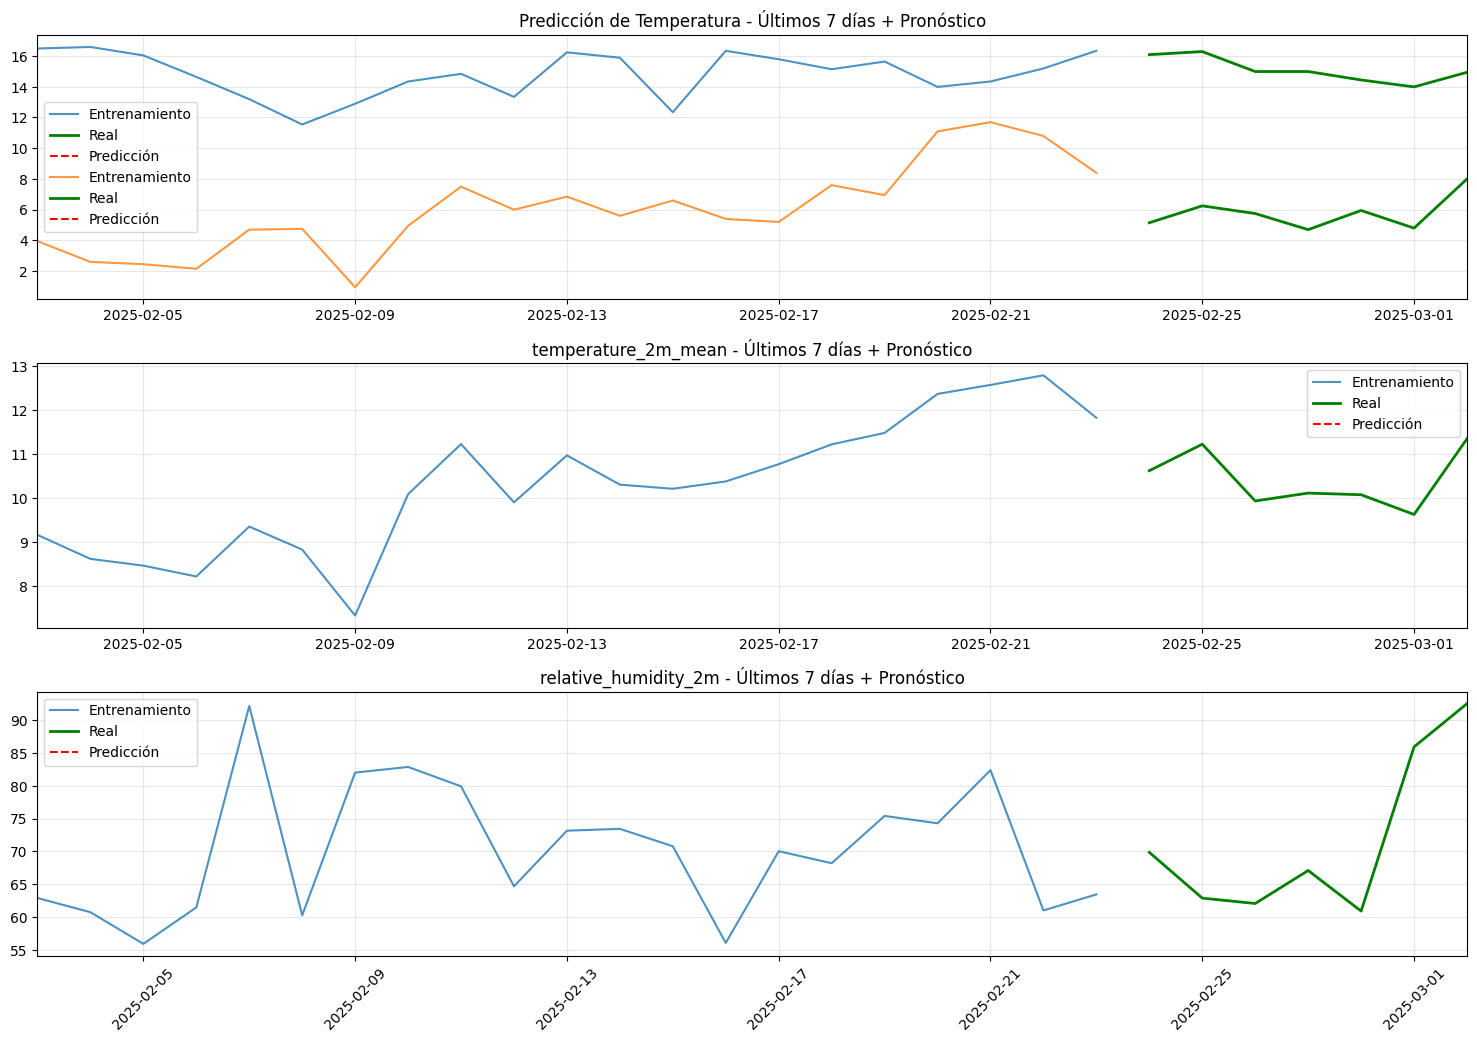

ValueError: Input contains NaN.

In [ ]:
# 2. Manejar valores faltantes
#df = df.interpolate(method='time')
from statsmodels.tsa.arima.model import ARIMA

def fit_arima(endog):
    model = auto_arima(
        endog,
        seasonal=True,  # Habilitar estacionalidad
        m=12,           # 12 meses
        order=(1, 1, 1),
        seasonal_order=(0, 1, 1, 12),  # Orden estacional fijo
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )
    return model

def fit_sarimax(endog):
    # Auto-detección básica de estacionalidad
    seasonal_period = 7  # Priorizar estacionalidad semanal
    
    model = SARIMAX(
        endog,
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1, seasonal_period),
        enforce_stationarity=False,
        enforce_invertibility=False,
        initialization='approximate_diffuse'  # Para series largas
    ).fit(disp=False, maxiter=250, method='powell')
    
    return model

latitud_longitud = [
    ("Madrid", 40.4168, -3.7038, "ESMAD2800000028240A"),
    ("Barcelona", 41.3888, 2.159, "ESMAD2800000028240A"),
    ("Hoyo de Manzanares", 40.6227, -3.9073, "ESMAD2800000028240A")
]



for ciudad, lat, lon, serie in latitud_longitud:
# 3. Dividir datos (últimos 7 días)
    df = recogida_df(ciudad)
    df["latitud"] = lat
    df["longitud"] = lon
    
    #df.to_excel("{ciudad}.xlsx")

    df = df.set_index('date').asfreq('D')
    #df = df[['temperature_2m']]
    df = df[['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean', 'relative_humidity_2m']]
    
    train = df.iloc[:-7]
    test = df.iloc[-7:]

    # 4. Función para ajustar modelo SARIMAX con parámetros limitados


    models = {}
    for col in df.columns:
        print(f"\n=== Modelo para {col} ===")
        models[col] = fit_arima(train[col])
        print(models[col])

    forecasts = pd.DataFrame(index=pd.date_range(start=test.index[0], periods=7, freq='D'))

    for col, model in models.items():
        forecasts[col] = model.predict(n_periods=7)
        print(forecasts[col])

    # 7. Visualización
    plt.figure(figsize=(15, 10))

    start_date = train.index[-21]  #dias para mostrar comparación
    end_date = test.index[6]

    plt.figure(figsize=(15, 10))

    # Temperatura ----
    plt.subplot(3,1,1)
    # Mostrar solo últimos 3 días de entrenamiento
    plt.plot(train['temperature_2m_max'].last('21D'), label='Entrenamiento', alpha=0.8)
    # Test y predicción completos
    plt.plot(test['temperature_2m_max'], label='Real', color='green', linewidth=2)
    plt.plot(forecasts['temperature_2m_max'], label='Predicción', color='red', linestyle='--')
    plt.title('Predicción de Temperatura - Últimos 7 días + Pronóstico')
    plt.xlim(start_date, end_date)  # Fijar límites temporales
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Temperatura ----
    plt.subplot(3,1,1)
    # Mostrar solo últimos 3 días de entrenamiento
    plt.plot(train['temperature_2m_min'].last('21D'), label='Entrenamiento', alpha=0.8)
    # Test y predicción completos
    plt.plot(test['temperature_2m_min'], label='Real', color='green', linewidth=2)
    plt.plot(forecasts['temperature_2m_min'], label='Predicción', color='red', linestyle='--')
    plt.title('Predicción de Temperatura - Últimos 7 días + Pronóstico')
    plt.xlim(start_date, end_date)  # Fijar límites temporales
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Humedad ----'temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean', 'relative_humidity_2m'
    plt.subplot(3,1,2)
    plt.plot(train['temperature_2m_mean'].last('21D'), label='Entrenamiento', alpha=0.8)
    plt.plot(test['temperature_2m_mean'], label='Real', color='green', linewidth=2)
    plt.plot(forecasts['temperature_2m_mean'], label='Predicción', color='red', linestyle='--')
    plt.title('temperature_2m_mean - Últimos 7 días + Pronóstico')
    plt.xlim(start_date, end_date)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Precipitación ----
    plt.subplot(3,1,3)
    plt.plot(train['relative_humidity_2m'].last('21D'), label='Entrenamiento', alpha=0.8)
    plt.plot(test['relative_humidity_2m'], label='Real', color='green', linewidth=2)
    plt.plot(forecasts['relative_humidity_2m'], label='Predicción', color='red', linestyle='--')
    plt.title('relative_humidity_2m - Últimos 7 días + Pronóstico')
    plt.xlim(start_date, end_date)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Formateo común
    plt.tight_layout()
    plt.xticks(rotation=45)  # Rotar fechas para mejor visualización
    plt.show()


    # 8. Métricas de evaluación
    from sklearn.metrics import mean_absolute_error, mean_squared_error

    metrics = {}
    for col in ['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean', 'relative_humidity_2m']:
        y_true = test[col]
        y_pred = forecasts[col]
        
        metrics[col] = {
            'MAE': mean_absolute_error(y_true, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'Error %': np.mean(np.abs((y_true - y_pred)/y_true)) * 100
        }

    # Imprimir métricas en formato tabla
    print("\n{:<25} {:<10} {:<10} {:<10}".format('Variable', 'MAE', 'RMSE', 'Error %'))
    for col, vals in metrics.items():
        print("{:<25} {:<10.2f} {:<10.2f} {:<10.2f}%".format(
            col, 
            vals['MAE'], 
            vals['RMSE'], 
            vals['Error %']
        ))

In [10]:
df

,temperature_2m_max,temperature_2m_min,temperature_2m_mean,relative_humidity_2m,sin_dia,cos_dia,sin_mes,cos_mes
date,,,,,,,,
2020-03-02 00:00:00+00:00,8.581000,3.131,6.308082,56.704771,9.749279e-01,-0.222521,1.000000,6.123234e-17
2020-03-03 00:00:00+00:00,13.781000,2.781,8.176833,72.207409,4.338837e-01,-0.900969,1.000000,6.123234e-17
2020-03-04 00:00:00+00:00,14.531000,8.031,10.745584,62.649034,-4.338837e-01,-0.900969,1.000000,6.123234e-17
2020-03-05 00:00:00+00:00,11.931001,4.631,8.435166,61.378813,-9.749279e-01,-0.222521,1.000000,6.123234e-17
2020-03-06 00:00:00+00:00,8.131001,2.381,5.068500,49.162910,-7.818315e-01,0.623490,1.000000,6.123234e-17
...,...,...,...,...,...,...,...,...
2025-02-26 00:00:00+00:00,10.781000,-1.469,4.593500,62.097260,-9.749279e-01,-0.222521,0.866025,5.000000e-01
2025-02-27 00:00:00+00:00,9.731000,3.381,5.891417,67.110503,-7.818315e-01,0.623490,0.866025,5.000000e-01
2025-02-28 00:00:00+00:00,11.831000,3.531,7.347666,60.945416,-9.797174e-16,1.000000,0.866025,5.000000e-01


In [ ]:
# 2. Manejar valores faltantes
#df = df.interpolate(method='time')
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
def fit_arima_optimized(endog, exog=None):
    return auto_arima(
        endog,
        exogenous=exog,
        seasonal=True,
        m=365,  # Estacionalidad anual para datos diarios
        information_criterion='aic',
        trace=True,
        stepwise=False,  # Permite búsqueda más exhaustiva
        n_jobs=-1,
        error_action='ignore'
    )

def fit_arima(endog, exog_cols=None):
    model = auto_arima(
        endog,
        seasonal=True,
        exog_cols = exog_cols,
        m=12,
        order=(1, 1, 1),
        seasonal_order=(0, 1, 1, 12),
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )
    return model

def fit_sarimax(endog, exog=None):
    seasonal_period = 7
    try:
        model = SARIMAX(
            endog,
            exog=exog,
            order=(1, 1, 1),
            seasonal_order=(1, 1, 1, seasonal_period),
            enforce_stationarity=False,
            enforce_invertibility=False,
            initialization='approximate_diffuse'
        ).fit(disp=False, maxiter=250, method='powell')
        return model
    except Exception as e:
        print(f"Error al ajustar SARIMAX: {e}")
        return None

latitud_longitud = [
    #("Madrid", 40.4168, -3.7038, "ESMAD2800000028240A"),
    #("Barcelona", 41.3888, 2.159, "ESMAD2800000028240A"),
    ("Hoyo de Manzanares", 40.6227, -3.9073, "ESMAD2800000028240A")
]

for ciudad, lat, lon, serie in latitud_longitud:
    df = recogida_df(ciudad)
    df["latitud"] = lat
    df["longitud"] = lon
    
    df = df.set_index('date').asfreq('D')
    
    # Añadir características cíclicas
    df['dia'] = df.index.day
    df['mes'] = df.index.month
    df['sin_dia'] = np.sin(2 * np.pi * df['dia'] / 7)
    df['cos_dia'] = np.cos(2 * np.pi * df['dia'] / 7)
    df['sin_mes'] = np.sin(2 * np.pi * df['mes'] / 12)
    df['cos_mes'] = np.cos(2 * np.pi * df['mes'] / 12)
    
    # ----> Añade manejo de NaN aquí <----
    df = df.dropna()  # Opción 1: Eliminar filas con NaN
    # df = df.fillna(method='ffill')  # Opción 2: Imputar
    
    # Seleccionar columnas incluyendo exog
    df = df[['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean', 
             'relative_humidity_2m', 'sin_dia', 'cos_dia', 'sin_mes', 'cos_mes']]
    
    # ----> Asegúrate de que la división train/test no cause NaN <----
    if len(df) < 7:
        print(f"¡Datos insuficientes para {ciudad}!")
        continue  # Saltar ciudades con pocos datos
    
    train = df.iloc[:-7]
    test = df.iloc[-7:]

    # Definir variables
    target_cols = ['temperature_2m_max', 'temperature_2m_min', 
                   'temperature_2m_mean', 'relative_humidity_2m']
    exog_cols = ['sin_dia', 'cos_dia', 'sin_mes', 'cos_mes']
    
    models = {}
    for col in target_cols:
        print(f"\n=== Modelo para {col} ===")
        # Entrenar con exog
        models[col] = fit_arima(train[col], train[exog_cols])
        #model = SARIMAX(endog, exog=exog, order=(1, 1, 1)).fit(disp=False)
        print(models[col])

    forecasts = pd.DataFrame(index=test.index)
    
    for col in target_cols:
        # Predecir con exog del test
        forecasts[col] = models[col].predict(exog=test[exog_cols])
        print(forecasts[col])

    # El resto del código (gráficos y métricas) permanece igual
    # ... (visualización y métricas)
        # Imprimir métricas en formato tabla

    # 7. Visualización
    plt.figure(figsize=(15, 10))

    start_date = train.index[-21]  #dias para mostrar comparación
    end_date = test.index[6]

    plt.figure(figsize=(15, 10))

    # Temperatura ----
    plt.subplot(3,1,1)
    # Mostrar solo últimos 3 días de entrenamiento
    plt.plot(train['temperature_2m_max'].last('21D'), label='Entrenamiento', alpha=0.8)
    # Test y predicción completos
    plt.plot(test['temperature_2m_max'], label='Real', color='green', linewidth=2)
    plt.plot(forecasts['temperature_2m_max'], label='Predicción', color='red', linestyle='--')
    plt.title('Predicción de Temperatura - Últimos 7 días + Pronóstico')
    plt.xlim(start_date, end_date)  # Fijar límites temporales
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Temperatura ----
    plt.subplot(3,1,1)
    # Mostrar solo últimos 3 días de entrenamiento
    plt.plot(train['temperature_2m_min'].last('21D'), label='Entrenamiento', alpha=0.8)
    # Test y predicción completos
    plt.plot(test['temperature_2m_min'], label='Real', color='green', linewidth=2)
    plt.plot(forecasts['temperature_2m_min'], label='Predicción', color='red', linestyle='--')
    plt.title('Predicción de Temperatura - Últimos 7 días + Pronóstico')
    plt.xlim(start_date, end_date)  # Fijar límites temporales
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Humedad ----'temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean', 'relative_humidity_2m'
    plt.subplot(3,1,2)
    plt.plot(train['temperature_2m_mean'].last('21D'), label='Entrenamiento', alpha=0.8)
    plt.plot(test['temperature_2m_mean'], label='Real', color='green', linewidth=2)
    plt.plot(forecasts['temperature_2m_mean'], label='Predicción', color='red', linestyle='--')
    plt.title('temperature_2m_mean - Últimos 7 días + Pronóstico')
    plt.xlim(start_date, end_date)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Precipitación ----
    plt.subplot(3,1,3)
    plt.plot(train['relative_humidity_2m'].last('21D'), label='Entrenamiento', alpha=0.8)
    plt.plot(test['relative_humidity_2m'], label='Real', color='green', linewidth=2)
    plt.plot(forecasts['relative_humidity_2m'], label='Predicción', color='red', linestyle='--')
    plt.title('relative_humidity_2m - Últimos 7 días + Pronóstico')
    plt.xlim(start_date, end_date)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Formateo común
    plt.tight_layout()
    plt.xticks(rotation=45)  # Rotar fechas para mejor visualización
    plt.show()


    # 8. Métricas de evaluación
    from sklearn.metrics import mean_absolute_error, mean_squared_error

    metrics = {}
    for col in ['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean', 'relative_humidity_2m']:
        y_true = test[col]
        y_pred = forecasts[col]
        
        metrics[col] = {
            'MAE': mean_absolute_error(y_true, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'Error %': np.mean(np.abs((y_true - y_pred)/y_true)) * 100
        }

    # Imprimir métricas en formato tabla
    print("\n{:<25} {:<10} {:<10} {:<10}".format('Variable', 'MAE', 'RMSE', 'Error %'))
    for col, vals in metrics.items():
        print("{:<25} {:<10.2f} {:<10.2f} {:<10.2f}%".format(
            col, 
            vals['MAE'], 
            vals['RMSE'], 
            vals['Error %']
        ))

C:\Users\JWinn01\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Iniciando conHoyo de Manzanares
Ruta absoluta: C:\Users\JWinn01\Desktop\IABD\Proyecto3\PrediccionMeteorologica\data\raw\Open_Meteo\daily\Hoyo de Manzanares
[DEBUG] Procesando año: 2020
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\daily\Hoyo de Manzanares\2020\Abril_meteo.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\daily\Hoyo de Manzanares\2020\Agosto_meteo.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\daily\Hoyo de Manzanares\2020\Diciembre_meteo.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\daily\Hoyo de Manzanares\2020\Julio_meteo.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\daily\Hoyo de Manzanares\2020\Junio_meteo.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\daily\Hoyo de Manzanares\2020\Marzo_meteo.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\daily\Hoyo de Manzanares\2020\Mayo_meteo.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\daily\Hoyo de Manzanares\2020\Noviembre_meteo.csv
[DEBUG] Leyendo archivo: ..\..\

ValueError: Column ds has timezone specified, which is not supported. Remove timezone.

In [ ]:
# Añadir importaciones necesarias
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Función para entrenar el modelo Random Forest
def fit_random_forest(X_train, y_train):
    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    return model

# Modificar el bucle principal
for ciudad, lat, lon, serie in latitud_longitud:
    df = recogida_df(ciudad)
    df["latitud"] = lat
    df["longitud"] = lon
    
    df = df.set_index('date').asfreq('D')
    
    # Añadir características cíclicas (mantenemos igual)
    df['dia'] = df.index.day
    df['mes'] = df.index.month
    df['sin_dia'] = np.sin(2 * np.pi * df['dia'] / 7)
    df['cos_dia'] = np.cos(2 * np.pi * df['dia'] / 7)
    df['sin_mes'] = np.sin(2 * np.pi * df['mes'] / 12)
    df['cos_mes'] = np.cos(2 * np.pi * df['mes'] / 12)
    
    # Manejo de NaN
    df = df.dropna()
    
    # Selección de características
    features = ['sin_dia', 'cos_dia', 'sin_mes', 'cos_mes', 'latitud', 'longitud']
    target_cols = ['temperature_2m_max', 'temperature_2m_min', 
                  'temperature_2m_mean', 'relative_humidity_2m']
    
    if len(df) < 7:
        print(f"¡Datos insuficientes para {ciudad}!")
        continue

    # División train/test
    train = df.iloc[:-7]
    test = df.iloc[-7:]
    
    models = {}
    forecasts = pd.DataFrame(index=test.index)
    
    # Entrenar modelo para cada target
    for col in target_cols:
        print(f"\n=== Entrenando modelo para {col} ===")
        
        # Entrenar el modelo
        model = fit_random_forest(train[features], train[col])
        models[col] = model
        
        # Predecir
        forecasts[col] = model.predict(test[features])
        
        # Evaluación en entrenamiento
        train_pred = model.predict(train[features])
        mae_train = mean_absolute_error(train[col], train_pred)
        print(f"MAE en entrenamiento: {mae_train:.2f}")

    # Visualización (mantenemos igual)
    plt.figure(figsize=(15, 10))
    start_date = train.index[-21]
    end_date = test.index[6]

    # Gráfico para temperature_2m_max
    plt.subplot(2,2,1)
    plt.plot(train[col].last('21D'), label='Entrenamiento')
    plt.plot(test['temperature_2m_max'], label='Real')
    plt.plot(forecasts['temperature_2m_max'], label='Predicción', linestyle='--')
    plt.title('Temperatura Máxima')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Repetir para las demás variables (temperature_2m_min, temperature_2m_mean, relative_humidity_2m)
    # ... (similar al código original)

    plt.tight_layout()
    plt.show()

    # Métricas de evaluación
    print("\nMétricas de evaluación:")
    print("{:<25} {:<10} {:<10} {:<10}".format('Variable', 'MAE', 'RMSE', 'Error %'))
    for col in target_cols:
        y_true = test[col]
        y_pred = forecasts[col]
        
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        error_perc = np.mean(np.abs((y_true - y_pred)/y_true)) * 100
        
        print("{:<25} {:<10.2f} {:<10.2f} {:<10.2f}%".format(col, mae, rmse, error_perc))

SyntaxError: '[' was never closed (4196979570.py, line 85)

: 

Iniciando conHoyo de Manzanares
Ruta absoluta: C:\Users\JWinn01\Desktop\IABD\Proyecto3\PrediccionMeteorologica\data\raw\Open_Meteo\daily\Hoyo de Manzanares
[DEBUG] Procesando año: 2020
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\daily\Hoyo de Manzanares\2020\Abril_meteo.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\daily\Hoyo de Manzanares\2020\Agosto_meteo.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\daily\Hoyo de Manzanares\2020\Diciembre_meteo.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\daily\Hoyo de Manzanares\2020\Julio_meteo.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\daily\Hoyo de Manzanares\2020\Junio_meteo.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\daily\Hoyo de Manzanares\2020\Marzo_meteo.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\daily\Hoyo de Manzanares\2020\Mayo_meteo.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\daily\Hoyo de Manzanares\2020\Noviembre_meteo.csv
[DEBUG] Leyendo archivo: ..\..\

C:\Users\JWinn01\AppData\Local\Temp\ipykernel_3152\1401003042.py:76: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  plt.plot(train[col].last('21D'), label='Entrenamiento')


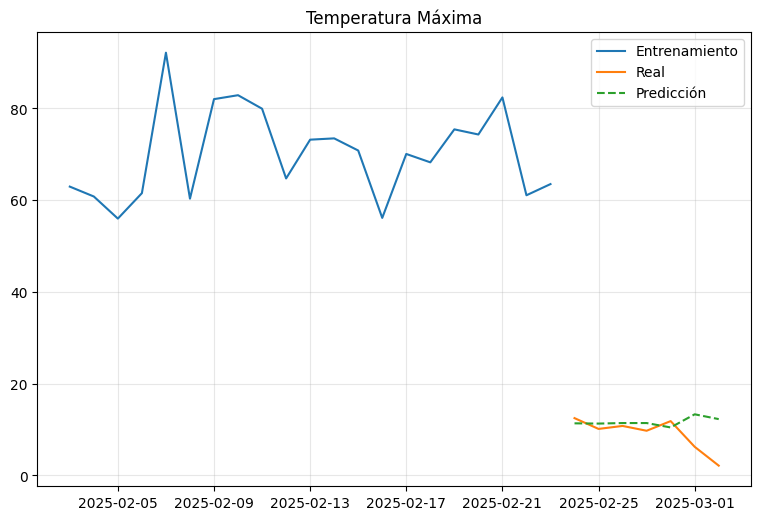


Métricas de evaluación:
Variable                  MAE        RMSE       Error %   
temperature_2m_max        3.32       4.79       92.10     %
temperature_2m_min        2.02       2.43       198.93    %
temperature_2m_mean       2.05       2.96       86.06     %
relative_humidity_2m      11.63      15.23      14.68     %


In [12]:
# Añadir importaciones necesarias
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Función para entrenar el modelo Random Forest
def fit_random_forest(X_train, y_train):
    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    return model

# Modificar el bucle principal
for ciudad, lat, lon, serie in latitud_longitud:
    df = recogida_df(ciudad)
    df["latitud"] = lat
    df["longitud"] = lon
    
    df = df.set_index('date').asfreq('D')
    
    # Añadir características cíclicas (mantenemos igual)
    df['dia'] = df.index.day
    df['mes'] = df.index.month
    df['sin_dia'] = np.sin(2 * np.pi * df['dia'] / 7)
    df['cos_dia'] = np.cos(2 * np.pi * df['dia'] / 7)
    df['sin_mes'] = np.sin(2 * np.pi * df['mes'] / 12)
    df['cos_mes'] = np.cos(2 * np.pi * df['mes'] / 12)
    
    # Manejo de NaN
    df = df.dropna()
    
    # Selección de características
    features = ['sin_dia', 'cos_dia', 'sin_mes', 'cos_mes', 'latitud', 'longitud']
    target_cols = ['temperature_2m_max', 'temperature_2m_min', 
                  'temperature_2m_mean', 'relative_humidity_2m']
    
    if len(df) < 7:
        print(f"¡Datos insuficientes para {ciudad}!")
        continue

    # División train/test
    train = df.iloc[:-7]
    test = df.iloc[-7:]
    
    models = {}
    forecasts = pd.DataFrame(index=test.index)
    
    # Entrenar modelo para cada target
    for col in target_cols:
        print(f"\n=== Entrenando modelo para {col} ===")
        
        # Entrenar el modelo
        model = fit_random_forest(train[features], train[col])
        models[col] = model
        
        # Predecir
        forecasts[col] = model.predict(test[features])
        
        # Evaluación en entrenamiento
        train_pred = model.predict(train[features])
        mae_train = mean_absolute_error(train[col], train_pred)
        print(f"MAE en entrenamiento: {mae_train:.2f}")

    # Visualización (mantenemos igual)
    plt.figure(figsize=(15, 10))
    start_date = train.index[-21]
    end_date = test.index[6]

    # Gráfico para temperature_2m_max
    plt.subplot(2,2,1)
    plt.plot(train[col].last('21D'), label='Entrenamiento')
    plt.plot(test['temperature_2m_max'], label='Real')
    plt.plot(forecasts['temperature_2m_max'], label='Predicción', linestyle='--')
    plt.title('Temperatura Máxima')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Repetir para las demás variables (temperature_2m_min, temperature_2m_mean, relative_humidity_2m)
    # ... (similar al código original)

    plt.tight_layout()
    plt.show()

    # Métricas de evaluación
    print("\nMétricas de evaluación:")
    print("{:<25} {:<10} {:<10} {:<10}".format('Variable', 'MAE', 'RMSE', 'Error %'))
    for col in target_cols:
        y_true = test[col]
        y_pred = forecasts[col]
        
        mae = mean_absolute_error(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        error_perc = np.mean(np.abs((y_true - y_pred)/y_true)) * 100
        
        print("{:<25} {:<10.2f} {:<10.2f} {:<10.2f}%".format(col, mae, rmse, error_perc))

In [10]:
df

,date,weather_code,temperature_2m_max,temperature_2m_min,temperature_2m_mean,year,month_number,month_name,relative_humidity_2m,estación,latitud,longitud
153,2020-03-02,61.0,8.581000,3.131,6.308082,2020,3,Marzo,56.704771,ESMAD2800000028240A,40.6227,-3.9073
154,2020-03-03,51.0,13.781000,2.781,8.176833,2020,3,Marzo,72.207409,ESMAD2800000028240A,40.6227,-3.9073
155,2020-03-04,51.0,14.531000,8.031,10.745584,2020,3,Marzo,62.649034,ESMAD2800000028240A,40.6227,-3.9073
156,2020-03-05,51.0,11.931001,4.631,8.435166,2020,3,Marzo,61.378813,ESMAD2800000028240A,40.6227,-3.9073
157,2020-03-06,3.0,8.131001,2.381,5.068500,2020,3,Marzo,49.162910,ESMAD2800000028240A,40.6227,-3.9073
...,...,...,...,...,...,...,...,...,...,...,...,...
1822,2025-02-26,3.0,10.781000,-1.469,4.593500,2025,2,Febrero,62.097260,ESMAD2800000028240A,40.6227,-3.9073
1823,2025-02-27,51.0,9.731000,3.381,5.891417,2025,2,Febrero,67.110503,ESMAD2800000028240A,40.6227,-3.9073
1824,2025-02-28,51.0,11.831000,3.531,7.347666,2025,2,Febrero,60.945416,ESMAD2800000028240A,40.6227,-3.9073
1825,2025-03-01,71.0,6.231000,1.881,4.737250,2025,3,Marzo,85.895707,ESMAD2800000028240A,40.6227,-3.9073


In [9]:
#IMPORTANTE NO BORRAR
#AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAH
latitud_longitud = [
    ("Madrid", 40.4168, -3.7038, "ESMAD2800000028240A"),
    ("Barcelona", 41.3888, 2.159, "ESMAD2800000028240A"),
    ("Hoyo de Manzanares", 40.6227, -3.9073, "ESMAD2800000028240A")
]


for ciudad, lat, lon, serie in latitud_longitud:
# 3. Dividir datos (últimos 7 días)
    df = recogida_df(ciudad)
    df["latitud"] = lat
    df["longitud"] = lon

    if "date" in df.columns and pd.api.types.is_datetime64_any_dtype(df["date"]):  
        df["date"] = df["date"].dt.tz_localize(None)  

    # Guardar en Excel  
    df.to_excel(f"{ciudad}.xlsx", index=False, engine="openpyxl")  

Iniciando conMadrid
Ruta absoluta: C:\Users\JWinn01\Desktop\IABD\Proyecto3\PrediccionMeteorologica\data\raw\Open_Meteo\daily\Madrid
[DEBUG] Procesando año: 2020
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\daily\Madrid\2020\Abril_meteo.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\daily\Madrid\2020\Agosto_meteo.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\daily\Madrid\2020\Diciembre_meteo.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\daily\Madrid\2020\Julio_meteo.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\daily\Madrid\2020\Junio_meteo.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\daily\Madrid\2020\Marzo_meteo.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\daily\Madrid\2020\Mayo_meteo.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\daily\Madrid\2020\Noviembre_meteo.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\daily\Madrid\2020\Octubre_meteo.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\daily\Madrid\

Iniciando conHoyo de Manzanares
Ruta absoluta: C:\Users\JWinn01\Desktop\IABD\Proyecto3\PrediccionMeteorologica\data\raw\Open_Meteo\daily\Hoyo de Manzanares
[DEBUG] Procesando año: 2020
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\daily\Hoyo de Manzanares\2020\Abril_meteo.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\daily\Hoyo de Manzanares\2020\Agosto_meteo.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\daily\Hoyo de Manzanares\2020\Diciembre_meteo.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\daily\Hoyo de Manzanares\2020\Julio_meteo.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\daily\Hoyo de Manzanares\2020\Junio_meteo.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\daily\Hoyo de Manzanares\2020\Marzo_meteo.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\daily\Hoyo de Manzanares\2020\Mayo_meteo.csv
[DEBUG] Leyendo archivo: ..\..\data\raw\Open_Meteo\daily\Hoyo de Manzanares\2020\Noviembre_meteo.csv
[DEBUG] Leyendo archivo: ..\..\

<Figure size 1500x1000 with 0 Axes>

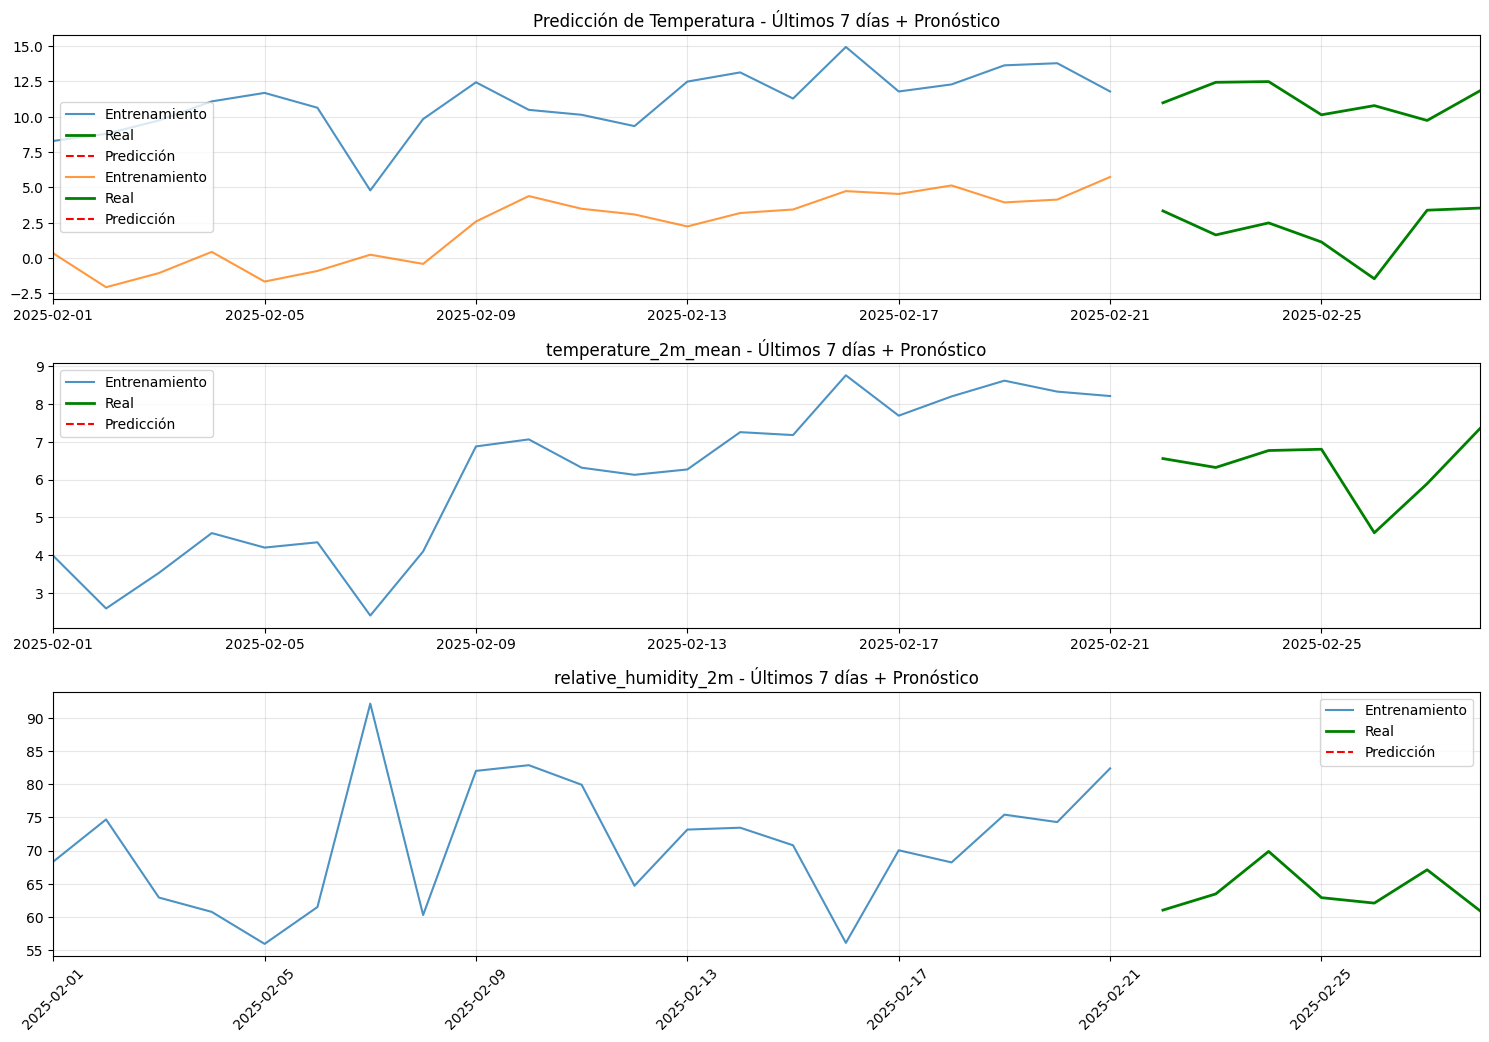

ValueError: Input contains NaN.

In [30]:
# 2. Manejar valores faltantes
#df = df.interpolate(method='time')
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm  # Necesitarás instalar pmdarima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
def fit_arima_optimized(endog, exog=None):
    return auto_arima(
        endog,
        exogenous=exog,
        seasonal=True,
        m=365,  # Estacionalidad anual para datos diarios
        information_criterion='aic',
        trace=True,
        stepwise=False,  # Permite búsqueda más exhaustiva
        n_jobs=-1,
        error_action='ignore'
    )

def fit_arima(endog, exog_cols=None):
    model = auto_arima(
        endog,
        seasonal=True,
        exog_cols = exog_cols,
        m=12,
        order=(1, 1, 1),
        seasonal_order=(0, 1, 1, 12),
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )
    return model

def fit_sarimax(endog, exog=None):
    seasonal_period = 7
    
    try:
        # 1. Validación de datos exógenos
        if exog is not None:
            exog = np.asarray(exog)
            if exog.ndim == 1:
                exog = exog.reshape(-1, 1)  # Convertir a 2D si es necesario
            if exog.shape[0] != len(endog):
                raise ValueError("exog y endog deben tener el mismo número de observaciones")

        # 2. Búsqueda automática de parámetros con validación
        auto_model = pm.auto_arima(
            endog,
            exogenous=exog,
            seasonal=True,
            m=seasonal_period,
            stepwise=True,
            suppress_warnings=True,
            error_action="ignore",
            maxiter=10  # Limitar para debugging
        )
        
        # 3. Verificar órdenes del modelo
        order = auto_model.order
        seasonal_order = auto_model.seasonal_order
        print(f"Parámetros encontrados: order={order}, seasonal_order={seasonal_order}")  # Debug
        
        # 4. Configuración segura del modelo
        model = SARIMAX(
            endog,
            exog=exog,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False,
            initialization='approximate_diffuse'
        )
        
        # 5. Ajuste sin parámetros iniciales problemáticos
        fit_result = model.fit(
            disp=True,
            maxiter=500,
            method='lbfgs',
            start_params=None  # No usar auto_model.params (pueden ser incompatibles)
        )
        
        return fit_result

    except Exception as e:
        print(f"Error ajustando SARIMAX: {str(e)}")
        return None


latitud_longitud = [
    #("Madrid", 40.4168, -3.7038, "ESMAD2800000028240A"),
    #("Barcelona", 41.3888, 2.159, "ESMAD2800000028240A"),
    ("Hoyo de Manzanares", 40.6227, -3.9073, "ESMAD2800000028240A")
]

for ciudad, lat, lon, serie in latitud_longitud:
    df = recogida_df(ciudad)
    df["latitud"] = lat
    df["longitud"] = lon
    
    df = df.set_index('date').asfreq('D')
    
    # Añadir características cíclicas
    df['dia'] = df.index.day
    df['mes'] = df.index.month
    df['sin_dia'] = np.sin(2 * np.pi * df['dia'] / 7)
    df['cos_dia'] = np.cos(2 * np.pi * df['dia'] / 7)
    df['sin_mes'] = np.sin(2 * np.pi * df['mes'] / 12)
    df['cos_mes'] = np.cos(2 * np.pi * df['mes'] / 12)
    
    # ----> Añade manejo de NaN aquí <----
    df = df.dropna()  # Opción 1: Eliminar filas con NaN
    # df = df.fillna(method='ffill')  # Opción 2: Imputar
    
    # Seleccionar columnas incluyendo exog
    df = df[['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean', 
             'relative_humidity_2m', 'sin_dia', 'cos_dia', 'sin_mes', 'cos_mes']]
    
    # ----> Asegúrate de que la división train/test no cause NaN <----
    if len(df) < 7:
        print(f"¡Datos insuficientes para {ciudad}!")
        continue  # Saltar ciudades con pocos datos
    
    train = df.iloc[:-7]
    test = df.iloc[-7:]

    # Definir variables
    target_cols = ['temperature_2m_max', 'temperature_2m_min', 
                   'temperature_2m_mean', 'relative_humidity_2m']
    exog_cols = ['sin_dia', 'cos_dia', 'sin_mes', 'cos_mes']
    
    models = {}
    for col in target_cols:
        print(f"\n=== Modelo para {col} ===")
        # Entrenar con exog
        models[col] = fit_sarimax(train[col], train[exog_cols])
        #model = SARIMAX(endog, exog=exog, order=(1, 1, 1)).fit(disp=False)
        print(models[col])

    forecasts = pd.DataFrame(index=test.index)
    
    for col in target_cols:
        # Predecir con exog del test
        forecasts[col] = models[col].predict(exog=test[exog_cols])
        print(forecasts[col])

    # El resto del código (gráficos y métricas) permanece igual
    # ... (visualización y métricas)
        # Imprimir métricas en formato tabla

    # 7. Visualización
    plt.figure(figsize=(15, 10))

    start_date = train.index[-21]  #dias para mostrar comparación
    end_date = test.index[6]

    plt.figure(figsize=(15, 10))

    # Temperatura ----
    plt.subplot(3,1,1)
    # Mostrar solo últimos 3 días de entrenamiento
    plt.plot(train['temperature_2m_max'].last('21D'), label='Entrenamiento', alpha=0.8)
    # Test y predicción completos
    plt.plot(test['temperature_2m_max'], label='Real', color='green', linewidth=2)
    plt.plot(forecasts['temperature_2m_max'], label='Predicción', color='red', linestyle='--')
    plt.title('Predicción de Temperatura - Últimos 7 días + Pronóstico')
    plt.xlim(start_date, end_date)  # Fijar límites temporales
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Temperatura ----
    plt.subplot(3,1,1)
    # Mostrar solo últimos 3 días de entrenamiento
    plt.plot(train['temperature_2m_min'].last('21D'), label='Entrenamiento', alpha=0.8)
    # Test y predicción completos
    plt.plot(test['temperature_2m_min'], label='Real', color='green', linewidth=2)
    plt.plot(forecasts['temperature_2m_min'], label='Predicción', color='red', linestyle='--')
    plt.title('Predicción de Temperatura - Últimos 7 días + Pronóstico')
    plt.xlim(start_date, end_date)  # Fijar límites temporales
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Humedad ----'temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean', 'relative_humidity_2m'
    plt.subplot(3,1,2)
    plt.plot(train['temperature_2m_mean'].last('21D'), label='Entrenamiento', alpha=0.8)
    plt.plot(test['temperature_2m_mean'], label='Real', color='green', linewidth=2)
    plt.plot(forecasts['temperature_2m_mean'], label='Predicción', color='red', linestyle='--')
    plt.title('temperature_2m_mean - Últimos 7 días + Pronóstico')
    plt.xlim(start_date, end_date)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Precipitación ----
    plt.subplot(3,1,3)
    plt.plot(train['relative_humidity_2m'].last('21D'), label='Entrenamiento', alpha=0.8)
    plt.plot(test['relative_humidity_2m'], label='Real', color='green', linewidth=2)
    plt.plot(forecasts['relative_humidity_2m'], label='Predicción', color='red', linestyle='--')
    plt.title('relative_humidity_2m - Últimos 7 días + Pronóstico')
    plt.xlim(start_date, end_date)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Formateo común
    plt.tight_layout()
    plt.xticks(rotation=45)  # Rotar fechas para mejor visualización
    plt.show()


    # 8. Métricas de evaluación
    from sklearn.metrics import mean_absolute_error, mean_squared_error

    metrics = {}
    for col in ['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean', 'relative_humidity_2m']:
        y_true = test[col]
        y_pred = forecasts[col]
        
        metrics[col] = {
            'MAE': mean_absolute_error(y_true, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
            'Error %': np.mean(np.abs((y_true - y_pred)/y_true)) * 100
        }

    # Imprimir métricas en formato tabla
    print("\n{:<25} {:<10} {:<10} {:<10}".format('Variable', 'MAE', 'RMSE', 'Error %'))
    for col, vals in metrics.items():
        print("{:<25} {:<10.2f} {:<10.2f} {:<10.2f}%".format(
            col, 
            vals['MAE'], 
            vals['RMSE'], 
            vals['Error %']
        ))